----

<html>
<center>
    <font size=6><b> Konkurs DataWorkshop </b></font> <br> 
    w ramach 10 edycji kursu "DS & ML w praktyce" <br><br>
    <b> Przewidywanie emisji CO </b> <br>
     3. miejsce <br> <br>
    <b> Adrian Skutnik </b>
            </center>
</html>

----

In [1]:
from pathlib import Path
from IPython.display import Image, clear_output
PICTURES_DIR = Path('pictures')

<h1 id="o_sobie"> Kilka słów o sobie </h1>

* Prawie 5 lat w bankowości - analityk danych związany z ryzykiem
* Codzienność zawodowa: 
    * coraz mniej `Excela` i `SQLa`
    * coraz więcej `Pythona` :D (ostatnio `Jupyter Notebook` 8 godzin dziennie, jak tylko nie mam spotkań)
    * Współpraca i wspieranie ludzi w zawodowych wyzwaniach (technicznych i biznesowych)
* W ramach firmy zmierzam w kierunku **ML/DS**. 
* Prywatnie - organy i inne muzyczne atrakcje

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

----

<h1 id="solution"> Rozwiązanie </h1>

*Cel:* **Przygotowanie spójnego, reużywalnego kodu od początku, żeby więcej można było eksperymentować w krótkim czasie.**
* Podział poszczególnych kroków na osobne notebooki

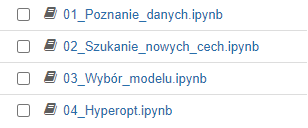

In [2]:
Image(PICTURES_DIR.joinpath('notebooks_names.png'))

* "Upchnięcie" kodu w pliczek `utils.py` i korzystanie ze stałych i funkcji na poziomie notebooków: 

```
import utils as u

df_all = u.prepare_data()
df_all = u.feature_engeenering(df_all)
df_train, df_test = u.split_data(df_all)
X = u.get_X(df_train)
y = u.get_y(df_train)
```

Albo ... 

```y_pred = u.fit_predict_model(model, df_train[u.FEATS], df_test[u.FEATS], target_log=True) ```

## Poznanie danych

### Jak wygląda zmienna celu?

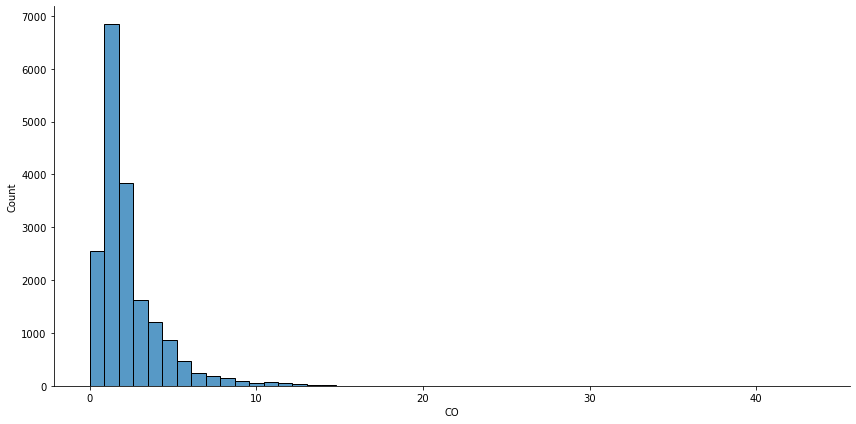

In [3]:
Image(PICTURES_DIR.joinpath('target.png'))

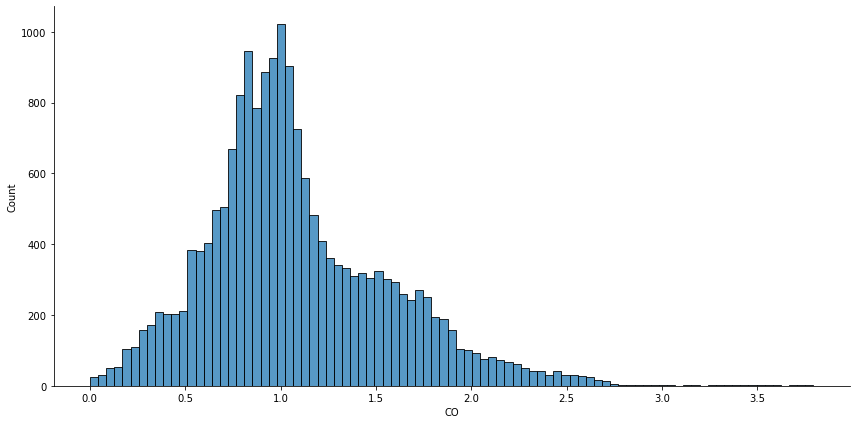

In [4]:
Image(PICTURES_DIR.joinpath('log_target.png'))

### Rozkład cech względem targetu (później również korelacje): 
```for col in df_train[feats]:
    plt.figure(figsize=(15, 6))
    sns.scatterplot(x=df_train[col], y=df_train['log_CO']);
    ```

Widać kilka korelacji zarówno na obrazkach, jak i licząc Pearsona.    
Intuicja, przy których cechach będzie warto zatrzymać się na dłużej:     
`GTEP`, `TIT`, `TAT`, `TEY` ... 

### Rozkład cech względem próbek treningowej i testowej:

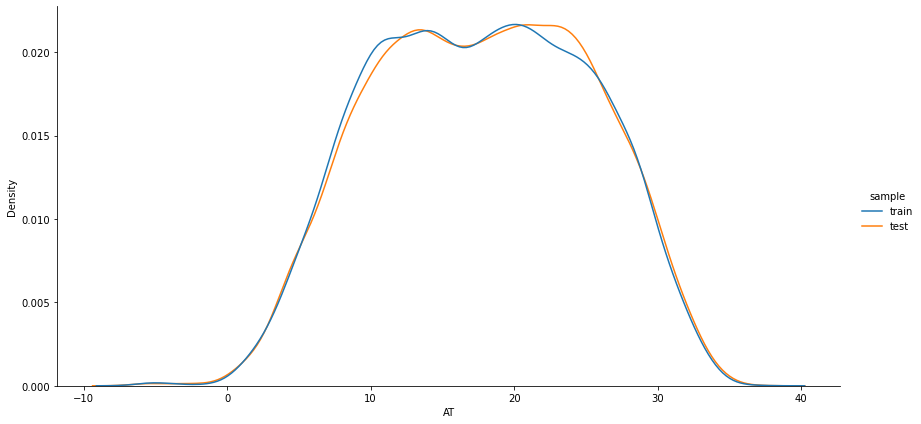

In [5]:
Image(PICTURES_DIR.joinpath('AT_distr.png'))

**Pytania:**     
* Kiedy decydujemy, że rozkłady w poszczególnych cechach pomiędzy `train` i `test` są na tyle różne, że ryzykownym jest używanie danej cechy w modelu? 
* Czy warto to w ogóle mierzyć? `K-S`, czy jakaś inna miara?
* Najbardziej odstaje pierwsza cecha `AT`, czy taka różnica już ją dyskwalifikuje?

<br><br><br><br>

## Szukanie cech

### Co mówią nazwy? Może już tu uda się coś połączyć? 

- `TIT` - Turbine inlet temperature C 
- `TAT` - Turbine after temperature C 
- `TEY` - Turbine energy yield MWH 

Ostatecznie wyszła mocna zmienna: 

`df_all['TAT - TIT'] =  df_all['TAT'] - df_all['TIT']`

i kilka innych kombinacji ... 

### Zmienne kategoryczne

`df_all['GTEP_cat'] = pd.qcut(df_all['GTEP'], 3).factorize()[0]`

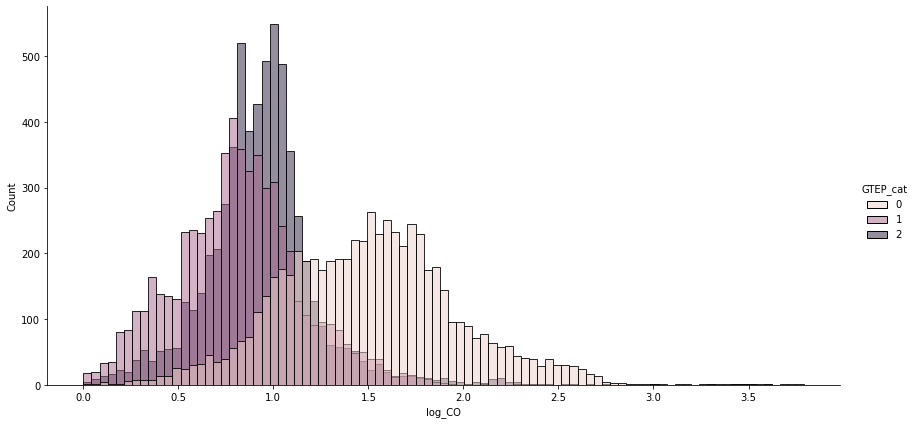

In [6]:
Image(PICTURES_DIR.joinpath('GTEP_cat.png'))

**Wynik:** Finalnie niewiele wniosły do modelu :( 

### Użycie modeli do szukania cech
 * Dodanie zmiennych losowych do szukania punktów odcięcia.
 * XGB i CatBoost na niewielkich parametrach.
 * `xgbfir` -- przydatna nowość w moim asortymencie.

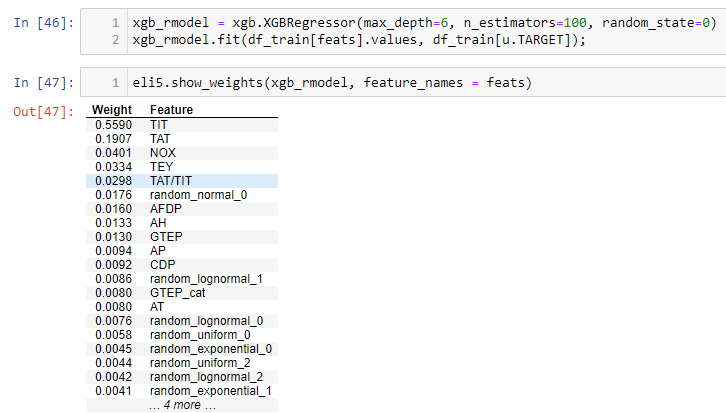

In [7]:
Image(PICTURES_DIR.joinpath('xgb_model_sel.png'))

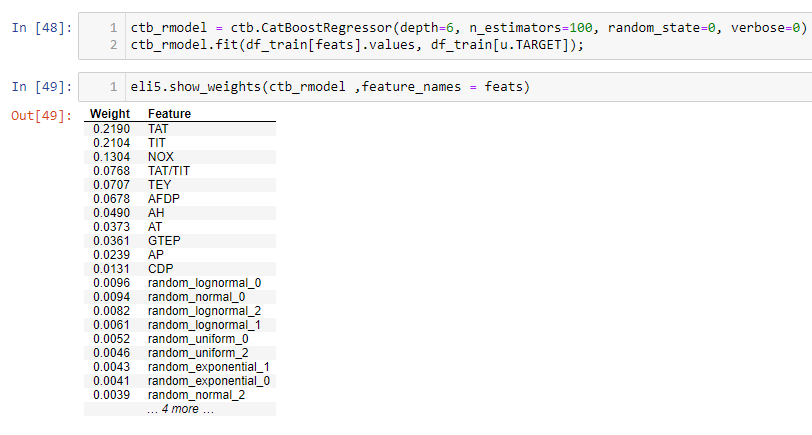

In [8]:
Image(PICTURES_DIR.joinpath('ctb_model_sel.png'))

**Pytania:**     
* W tym wypadku CatBoost w wagach "rozkłada się" po charakterystykach a XGBoost "faworyzuje" jedną. To specyfika danych, czy jednak te dwie implementacje GB są różne i należy na to uważać? 

<br><br><br><br>

## Wybór modelu

1. Różne modele drzewiaste na niewielkich parametrach (`max_depth=10, n_estimators=200`)    
   


2. Porównanie targetu i `log(target)`. 
    * `Log(target)` sprawdził się dużo lepiej (0.55 vs 0.50 w pierwszych eksperymentach)


3. Różne zestawy cech (od pełnej listy, do selekcji najmocniejszych)
    * Finalny model zbudowany na wybranych cechach (odrzucone cechy kategoryczne i transformacje matematyczne)

Lepsze wyniki na `cv` lokalnie oraz na `kaggle` + sugestia z pytania powyżej spowodowały, że wybór padł na **CATBoostRegressor**.

## Hyperopt

Pierwsze, świadome i konsekwentne użycie `hyperopt`'a :D

Finalne parametry: 

```
ctb_params = {'n_estimators': 1100.0, 
              'l2_leaf_reg': 2.0391558389346702, 
              'learning_rate': 0.050701938569694155, 
              'max_depth': 15.0
             }

model = ctb.CatBoostRegressor(**ctb_params)

y_pred = u.fit_predict_model(model, df_train[u.FEATS], df_test[u.FEATS], target_log=True) 
df_test.loc[:, 'CO'] = y_pred
```

<br><br><br><br>

<br><br><br><br>

----

<h1 id="difficulties"> Bolączki </h1>

1. Szukanie cech kategorycznych i transformat (logarytmy, sqrt, sumy, różnice) niewiele wnosiły do wyników modelu (nie przeskakiwały cech oryginalnych). 
2. Duży czas oczekiwania (w odniesieniu do parametrów i rozmiaru danych) na wyniki modelowania.
    * lepsze dobranie parametrów `cv` i `lc_plot`?
    * trenowanie na próbce vs na całym zbiorze?
    * CatBoost trenuje się szybciej niż XGBoost? 
    
3. `Hyperopt` -- plany były większe niż możliwości czasowe ... 

<br><br><br><br>

<br><br><br><br>

----

<h1 id="surprise"> Radości </h1>

1. Od początku wrzucania wyników (dzięki stosowaniu `cv` i `lc_plot`) stabilne i "w miarę" przewidywalne wyniki. 
    * Choć rozjazd między `train` przy eksperymentowaniu a `test` na `kaggle` dalej mnie martwi :P 
    
    
2. Problem z `underfittingiem` bardziej niż z `overfittingiem` :)

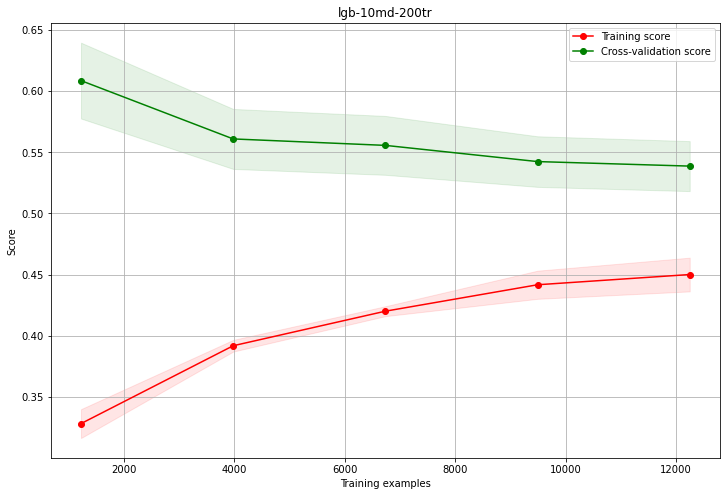

In [9]:
Image(PICTURES_DIR.joinpath('learning_curve.png'))

3. Mimo braku czasu (albo właśnie dlatego) - uporządkowany kod


4. Feature Engeenering znów **nie zawiódł!**

<br><br><br><br>

<br><br><br><br>

----

<h1 id="delta"> <latex> $\Delta$ </latex>Delta rozwoju </h1>

* Coraz większa świadomość jak pracować efektywnie z problemem.
* Porządek w kodzie pozwala pracować w niewielkich dostępnych interwałach czasu. 
* Nowe narzędzia w asortymencie data scientist'y 

<center>
    <a href="https://github.com/AdiSk325/DataWorkshop_pml_konkurs">Zapraszam do zapoznania się z rozwiązaniem!</a>
    </center>

In [11]:
!jupyter nbconvert --to html --no-input "Prezentacja.ipynb"
clear_output()